In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from hs2 import herdingspikes
from Probe import NeuralProbe, NeuroPixel, BioCam
import numpy as np

%matplotlib inline

In [2]:
# data = h5py.File(data_path, 'r')
# data = np.fromfile(data_path, dtype=np.int16).reshape((1800000,385))

# Probe = NeuroPixel(fps=30000)
Probe = BioCam()
H = herdingspikes(Probe)

In [5]:
# Probe.show(figwidth=12, show_neighbors=[-20])

In [6]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

# data_path = '/home/cole/neuropixeldata/rawDataSample.bin'
data_path = '/data/MEA/neuropixel/rawDataSample.bin'
data_format = 'flat'

data_path = '/data/MEA/LightStim/P29_16_07_14/P29_16_05_14_retina02_left_stim3_fullarray_fullfieldHDF5.brw'
data_format = 'biocam'

to_localize = True
cutout_start = 10
cutout_end = 30
threshold = 12 #20

In [8]:
H.DetectFromRaw(data_path,
                to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, data_format=data_format)

# # OR

# H.LoadDetected()

3Brain data format: 100
# Sampling rate: 7022
# Number of recorded channels: 4096
# Analysing frames: 912032, Seconds:129.881008418
# Frames before spike in cutout: 7
# Frames after spike in cutout: 15
# tcuts: 22 42
# tInc: 200000
# Analysing 200000 frames; -22 200042
# Analysing 200000 frames; 199978 400042
# Analysing 200000 frames; 399978 600042
# Analysing 200000 frames; 599978 800042
# Analysing 111990 frames; 799978 912032
# Time taken for detection: 0:02:23.636584
# Time per frame: 0:00:00.157491
# Time per sample: 0:00:00.000038


Spike detected at channel:  337
Spike detected at frame:  5187


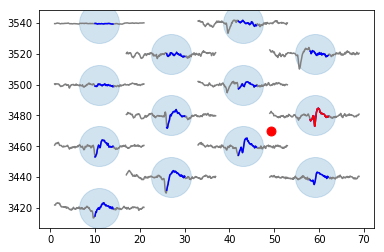

In [6]:
H.PlotTracesChannels(data_path, 1022)

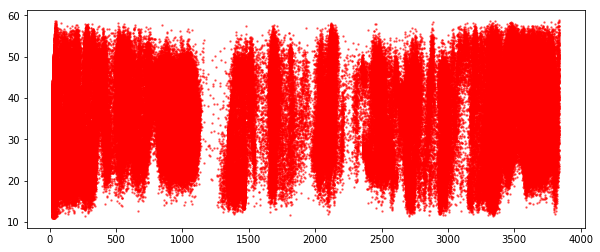

In [7]:
plt.figure(figsize=(10, 4))
H.PlotAll(invert=True, s=2, alpha=0.5)

In [8]:
H.CombinedClustering(alpha=40,
                    bandwidth = 20, bin_seeding=True, min_bin_freq=10,
                    pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

total number of seeds: 7103
seeds/job: 1776
using 4 cpus


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.6min finished


Number of estimated clusters: 192


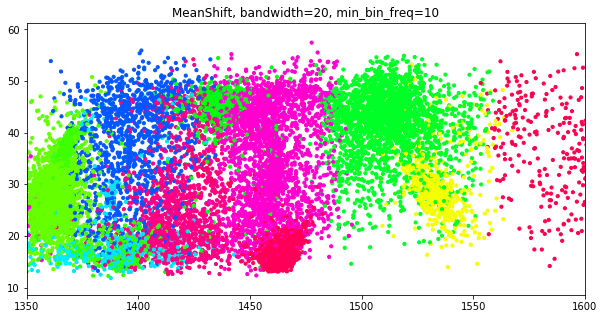

In [9]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=10)
plt.xlim((1350,1600))
plt.title("MeanShift, bandwidth=20, min_bin_freq=10")

In [10]:
from sklearn.cluster import DBSCAN
H.CombinedClustering(eps=8, alpha=40, clustering_algorithm=DBSCAN,
                    min_samples=5, pca_ncomponents=2, pca_whiten=True,
                    n_jobs=-1)

Number of estimated clusters: 751


/home/mhennig/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mhennig/.local/lib/python3.5/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


/home/mhennig/.local/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


(1350, 1600)

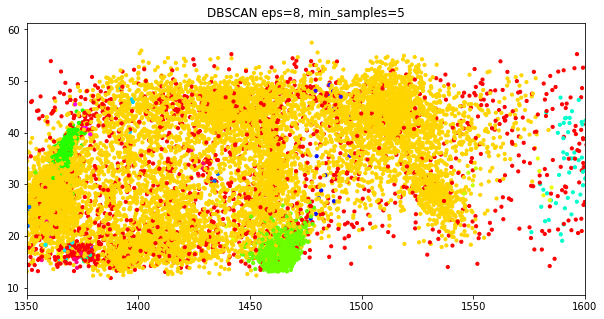

In [11]:
plt.figure(figsize=(10, 5))
H.PlotAll(invert=True, s=8)
plt.title("DBSCAN eps=8, min_samples=5")
plt.xlim((1350,1600))


In [ ]:
units = (121,4)

H.PlotShapes(units)